In [7]:
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [8]:
!pip install -q optuna

## 1. Library import

In [9]:
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import optuna

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'NanumBarunGothic'

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Load

In [11]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
data_path = '/content/drive/MyDrive/Notebooks/data/final_data.csv'
data = pd.read_csv(data_path)

# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', data.shape)

Train data shape :  (1128094, 39)


In [12]:
# 2020년 이후 데이터만 사용해보자.
data = data[data['계약년'] >= 2020]
data

,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,target,is_test,지번주소,...,도로명_실거래가순위,도로_실거래가순위,동_실거래가순위,재건축,기준금리,CLI,자치구별 지하철 승객 수,아파트전세가격지수,학군,구_연평균_표준지공시지가
201009,개포더샵트리에,105.8064,202306,29,8,2021,개포로 311,240000.0,0,서울특별시 강남구 개포동 651-1,...,1127,77,48,0.0,3.25,72.9,161925782.0,69.3,1,1.740307e+07
201010,개포주공5단지,74.2500,202301,3,10,1983,삼성로4길 17,210000.0,0,서울특별시 강남구 개포동 187,...,903,30,48,0.0,3.25,72.9,161925782.0,69.3,1,1.740307e+07
201011,개포주공5단지,61.1900,202302,5,12,1983,삼성로4길 17,199000.0,0,서울특별시 강남구 개포동 187,...,903,30,48,0.0,3.25,73.0,161925782.0,69.2,1,1.740307e+07
201012,개포주공5단지,83.1700,202304,7,13,1983,삼성로4길 17,249000.0,0,서울특별시 강남구 개포동 187,...,903,30,48,0.0,3.25,73.0,161925782.0,69.2,1,1.740307e+07
201013,개포주공5단지,83.1700,202304,29,10,1983,삼성로4길 17,277000.0,0,서울특별시 강남구 개포동 187,...,903,30,48,0.0,3.25,72.9,161925782.0,69.3,1,1.740307e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,신내우디안1단지,84.6500,202307,19,13,2014,신내역로1길 85,NaN,1,서울특별시 중랑구 신내동 816,...,2695,274,280,0.0,5.00,64.5,73185743.0,53.6,0,3.935362e+06
1128090,신내우디안1단지,84.6200,202307,25,12,2014,신내역로1길 85,NaN,1,서울특별시 중랑구 신내동 816,...,2695,274,280,0.0,4.50,63.0,73185743.0,53.4,0,3.935362e+06
1128091,신내우디안1단지,101.6500,202308,27,12,2014,신내역로1길 85,NaN,1,서울특별시 중랑구 신내동 816,...,2695,274,280,0.0,4.50,63.0,73185743.0,53.4,0,3.935362e+06
1128092,신내우디안1단지,84.9400,202309,2,18,2014,신내역로1길 85,NaN,1,서울특별시 중랑구 신내동 816,...,2695,274,280,0.0,4.50,63.2,73185743.0,53.4,0,3.935362e+06


In [13]:
data = data.rename(columns={"구_연평균_표준지공시지가" : "공시지가"})
data.columns

Index(['아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target', 'is_test',
       '지번주소', '좌표X', '좌표Y', 'k-복도유형', 'k-단지분류', '주차대수', '구', '동', '계약년',
       '계약월', '계약년월일', '도로', '강남여부', '부촌여부', '상위아파트여부', 'top아파트거리', '브랜드명',
       '건물연식', '대장아파트거리', '인근지하철역개수', '도로명_실거래가순위', '도로_실거래가순위', '동_실거래가순위',
       '재건축', '기준금리', 'CLI', '자치구별 지하철 승객 수', '아파트전세가격지수', '학군', '공시지가'],
      dtype='object')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165862 entries, 201009 to 1128093
Data columns (total 39 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   아파트명           165236 non-null  object 
 1   전용면적           165862 non-null  float64
 2   계약년월           165862 non-null  int64  
 3   계약일            165862 non-null  int64  
 4   층              165862 non-null  int64  
 5   건축년도           165862 non-null  int64  
 6   도로명            165862 non-null  object 
 7   target         156590 non-null  float64
 8   is_test        165862 non-null  int64  
 9   지번주소           165862 non-null  object 
 10  좌표X            165862 non-null  float64
 11  좌표Y            165862 non-null  float64
 12  k-복도유형         125981 non-null  object 
 13  k-단지분류         125757 non-null  object 
 14  주차대수           165862 non-null  float64
 15  구              165862 non-null  object 
 16  동              165862 non-null  object 
 17  계약년            165862 n

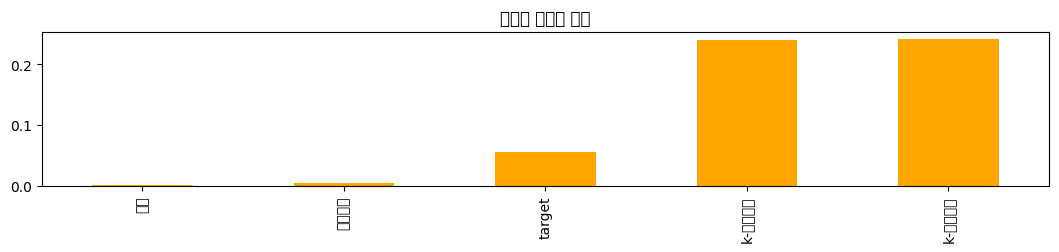

In [15]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = data.isnull().sum() / data.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [16]:
# 강남구, 서초구, 용산구, 송파구, 성동구만을 위한 고가형 모델을 따로 만드는 방식으로 접근
data.groupby('구')['target'].mean().sort_values(ascending=False)

구
강남구     197475.798214
서초구     193288.986893
용산구     175549.200341
송파구     141337.456353
성동구     125710.798121
광진구     111440.788636
마포구     107813.279425
동작구     101841.231439
양천구      95576.588567
영등포구     94533.132604
중구       91140.069152
강동구      89379.613799
종로구      86384.477184
서대문구     82651.918099
성북구      74022.882955
동대문구     73691.972413
강서구      71615.892676
은평구      66540.466296
관악구      65744.583153
강북구      59055.489344
노원구      57518.663856
구로구      57087.617957
중랑구      55637.215647
금천구      53718.703343
도봉구      49826.017843
Name: target, dtype: float64

## 3. 이상치 처리 > 진행 X
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

In [18]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(data.shape)

(165862, 39)


In [19]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [21]:
# 이상치 제거 후 자치구별 타겟값
data.groupby('구')['target'].mean().sort_values(ascending=False)

구
강남구     197475.798214
서초구     193288.986893
용산구     175549.200341
송파구     141337.456353
성동구     125710.798121
광진구     111440.788636
마포구     107813.279425
동작구     101841.231439
양천구      95576.588567
영등포구     94533.132604
중구       91140.069152
강동구      89379.613799
종로구      86384.477184
서대문구     82651.918099
성북구      74022.882955
동대문구     73691.972413
강서구      71615.892676
은평구      66540.466296
관악구      65744.583153
강북구      59055.489344
노원구      57518.663856
구로구      57087.617957
중랑구      55637.215647
금천구      53718.703343
도봉구      49826.017843
Name: target, dtype: float64

In [22]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(data.shape)

(165862, 39)


In [23]:
data['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    156590
1      9272
Name: is_test, dtype: int64

## 4. 실거래가가 높은 데이터 업샘플링

In [24]:
# 데이터 수가 적은 높은 실거래가의 데이터를 복사하여 넣어줌
df_high_cases1 = data[data['target'] >= 1300000]
data = pd.concat([data, df_high_cases1])
data = pd.concat([data, df_high_cases1])

df_high_cases2 = data[data['target'] >= 1000000 & (data['target'] < 1300000)]
data = pd.concat([data, df_high_cases2])
data = pd.concat([data, df_high_cases2])

In [25]:
data.shape

(479060, 39)

## 5. Model Training

In [26]:
dt_train = data.query('is_test==0').reset_index()
dt_test = data.query('is_test==1').reset_index()

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(469788, 39) (9272, 39)


In [27]:
# 사용할 컬럼만 추출 아파트명 추가
final_cols = ['도로명_실거래가순위', '전용면적', '계약년', '아파트명',
                  '계약월', '동_실거래가순위', '좌표X', '좌표Y', '건축년도',
                  '부촌여부', '상위아파트여부', '대장아파트거리', '도로_실거래가순위', '구',
                  '주차대수', '인근지하철역개수', '브랜드명', '건물연식', '계약년월일',
                  'top아파트거리', 'target','재건축', '기준금리', 'CLI',
                  '자치구별 지하철 승객 수', '공시지가', '아파트전세가격지수', '학군'
                  ]

dt_train = dt_train[final_cols]
dt_test = dt_test[final_cols]

### 5.1 고가용/저가용 모델을 위한 학습데이터 분리

In [28]:
high_list = ['서초구', '강남구', '용산구', '송파구', '성동구']

# train
high_train = dt_train[dt_train['구'].isin(high_list)]
low_train = dt_train[~dt_train['구'].isin(high_list)]

# test
high_test = dt_test[dt_test['구'].isin(high_list)]
low_test = dt_test[~dt_test['구'].isin(high_list)]

In [29]:
print(high_train.shape, low_train.shape)

(97422, 28) (372366, 28)


### 5.2 범주형 변수 Encoding

- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

In [30]:
numerical_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        numerical_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("수치형 변수:", numerical_columns_v2)
print("범주형 변수:", categorical_columns_v2)

수치형 변수: ['도로명_실거래가순위', '전용면적', '계약년', '계약월', '동_실거래가순위', '좌표X', '좌표Y', '건축년도', '부촌여부', '상위아파트여부', '대장아파트거리', '도로_실거래가순위', '주차대수', '인근지하철역개수', '건물연식', '계약년월일', 'top아파트거리', 'target', '재건축', '기준금리', 'CLI', '자치구별 지하철 승객 수', '공시지가', '아파트전세가격지수', '학군']
범주형 변수: ['아파트명', '구', '브랜드명']


### 5.2.1. 고가형 모델 학습 데이터

In [31]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders_high = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # 모든 데이터를 문자열로 변환
    all_values = pd.concat([high_train[col], high_test[col]], axis=0).astype(str)

    # Label-Encoding을 fit
    lbl.fit(all_values)

    # 변환 적용
    high_train[col] = lbl.transform(high_train[col].astype(str))
    high_test[col] = lbl.transform(high_test[col].astype(str))

    # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.
    label_encoders_high[col] = lbl

100%|██████████| 3/3 [00:00<00:00, 11.85it/s]


In [32]:
high_train.head(1)

,도로명_실거래가순위,전용면적,계약년,아파트명,계약월,동_실거래가순위,좌표X,좌표Y,건축년도,부촌여부,...,계약년월일,top아파트거리,target,재건축,기준금리,CLI,자치구별 지하철 승객 수,공시지가,아파트전세가격지수,학군
0,1127,105.8064,2023,85,6,48,127.056394,37.484892,2021,0,...,20230629,500.0,240000.0,0.0,3.25,72.9,161925782.0,1.740307e+07,69.3,1


### 5.2.2. 저가형 모델 학습 데이터

In [33]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders_low = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # 모든 데이터를 문자열로 변환
    all_values = pd.concat([low_train[col], low_test[col]], axis=0).astype(str)

    # Label-Encoding을 fit
    lbl.fit(all_values)

    # 변환 적용
    low_train[col] = lbl.transform(low_train[col].astype(str))
    low_test[col] = lbl.transform(low_test[col].astype(str))

    # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.
    label_encoders_low[col] = lbl

100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


In [34]:
low_train.head(1)

,도로명_실거래가순위,전용면적,계약년,아파트명,계약월,동_실거래가순위,좌표X,좌표Y,건축년도,부촌여부,...,계약년월일,top아파트거리,target,재건축,기준금리,CLI,자치구별 지하철 승객 수,공시지가,아파트전세가격지수,학군
856,2200,59.99,2022,155,12,180,127.1731,37.572621,2020,0,...,20221229,500.0,55000.0,0.0,3.25,72.9,161925782.0,6310000.0,69.1,1


## 5.3 Model Training

## 5.3.1. 고가형 모델 학습

In [35]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [36]:
# # Target과 독립변수들을 분리해줍니다.
# X_train_high_all = high_train.drop(['target', '계약년월일'], axis=1)
# y_train_high_all = high_train['target']

# # Custom validation split - 최근 20% 데이터를 validation set으로 나눔
# high_train = high_train.sort_values('계약년월일')
# cut = int(len(high_train)*0.9)
# train_split = high_train[:cut]
# valid_split = high_train[cut:]

# X_train_high = train_split.drop(['target', '계약년월일'], axis=1)
# y_train_high = train_split['target']
# X_val_high = valid_split.drop(['target', '계약년월일'], axis=1)
# y_val_high = valid_split['target']

# lgb_params_high = {
#             'n_estimators': 2048,
#             'force_col_wise': True
#             }

# model_high = LGBMRegressor(**lgb_params_high)

In [37]:
# # 모델 학습 및 평가
# model_high.fit(X_train_high, y_train_high)
# pred_high = model_high.predict(X_val_high)

# # 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
# print(f'Validation RMSE: {mean_squared_error(y_val_high, pred_high, squared=False)}')

In [42]:
# Target과 독립변수들을 분리해줍니다.
X_train_high_all = high_train.drop(['target', '계약년월일'], axis=1)
y_train_high_all = high_train['target']

# Custom validation split - 최근 20% 데이터를 validation set으로 나눔
high_train = high_train.sort_values('계약년월일')
cut = int(len(high_train)*0.9)
train_split = high_train[:cut]
valid_split = high_train[cut:]

X_train_high = train_split.drop(['target', '계약년월일'], axis=1)
y_train_high = train_split['target']
X_val_high = valid_split.drop(['target', '계약년월일'], axis=1)
y_val_high = valid_split['target']

# Objective 함수 정의: 하이퍼파라미터 최적화를 위한 목적 함수
def objective(trial):
    # 하이퍼파라미터 탐색 범위 지정
    lgb_params_high = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0),
        'force_col_wise': True,
        'device' : 'gpu',
        'verbose' : -1
    }

    # 모델 생성
    model_high = LGBMRegressor(**lgb_params_high)

    # 모델 학습
    model_high.fit(X_train_high, y_train_high)

    # 검증 세트 예측
    pred_high = model_high.predict(X_val_high)

    # 검증 세트에 대한 RMSE 계산하여 반환
    return mean_squared_error(y_val_high, pred_high, squared=False)

# Optuna study 생성 및 실행
study = optuna.create_study(direction='minimize')  # 최소화를 목표로 함
study.optimize(objective, n_trials=1000)  # 5000번의 trial을 실행하여 최적의 하이퍼파라미터 탐색

# 최적의 하이퍼파라미터 출력
print('Best trial:')
print(study.best_trial.params)

# 최적의 하이퍼파라미터로 모델 재학습
best_params = study.best_trial.params
model_high = LGBMRegressor(**best_params)
model_high.fit(X_train_high, y_train_high)

# 최종 검증 세트 예측 및 평가
pred_high = model_high.predict(X_val_high)
print(f'Validation RMSE with Optuna: {mean_squared_error(y_val_high, pred_high, squared=False)}')

[I 2024-04-01 18:45:57,619] A new study created in memory with name: no-name-45a85816-8db0-4930-b016-eebc3f19fbf3
[I 2024-04-01 18:46:15,943] Trial 0 finished with value: 24403.82037285811 and parameters: {'n_estimators': 1187, 'learning_rate': 0.0044793761917788074, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 94, 'subsample': 0.7363544271539628, 'colsample_bytree': 0.7169634200553796, 'reg_alpha': 4.2443517421610434e-05, 'reg_lambda': 0.12626578355976384}. Best is trial 0 with value: 24403.82037285811.
[I 2024-04-01 18:46:19,317] Trial 1 finished with value: 53530.249592138054 and parameters: {'n_estimators': 793, 'learning_rate': 0.0018936477350123496, 'num_leaves': 96, 'max_depth': 3, 'min_child_samples': 79, 'subsample': 0.7438240154653357, 'colsample_bytree': 0.6260863184124346, 'reg_alpha': 0.037383972974860354, 'reg_lambda': 1.1457383655238915e-07}. Best is trial 0 with value: 24403.82037285811.
[I 2024-04-01 18:46:41,826] Trial 2 finished with value: 23938.6709475432

Best trial:
{'n_estimators': 2600, 'learning_rate': 0.07864445649598537, 'num_leaves': 201, 'max_depth': 6, 'min_child_samples': 31, 'subsample': 0.977597547884873, 'colsample_bytree': 0.7513924026100998, 'reg_alpha': 3.0156826403865366e-06, 'reg_lambda': 59.862286965550986}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2503
[LightGBM] [Info] Number of data points in the train set: 87679, number of used features: 26
[LightGBM] [Info] Start training from score 165418.193958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

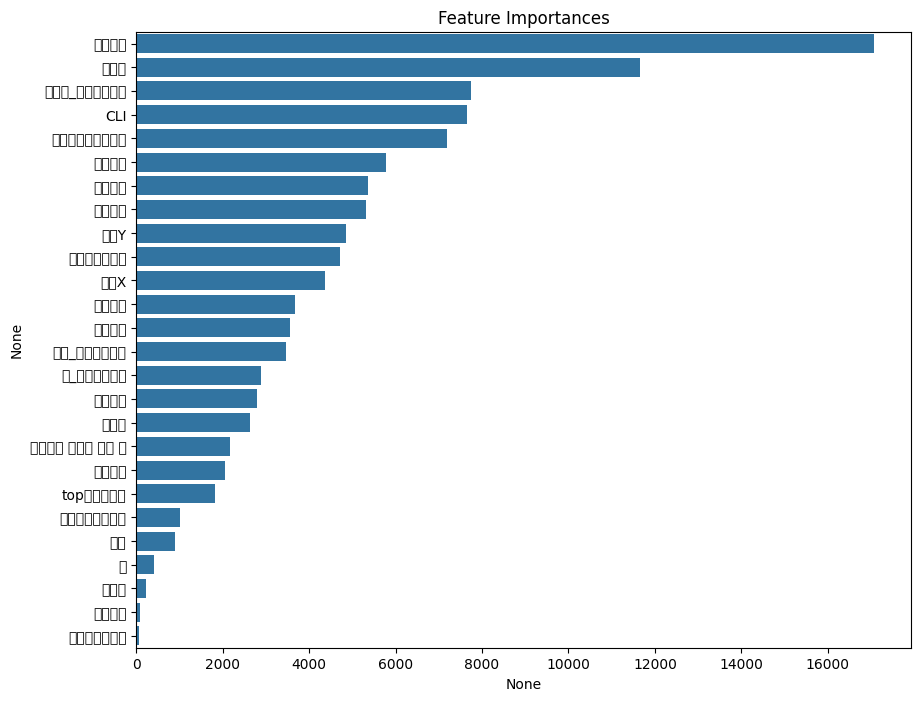

In [43]:
# 위 feature importance를 시각화해봅니다.
importances_high = pd.Series(model_high.feature_importances_, index=list(X_train_high.columns))
importances_high = importances_high.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances_high, y=importances_high.index)
plt.show()

## 5.3.2 저가형 모델 학습

In [ ]:
# Target과 독립변수들을 분리해줍니다.
X_train_low_all = low_train.drop(['target', '계약년월일'], axis=1)
y_train_low_all = low_train['target']

# Custom validation split - 최근 20% 데이터를 validation set으로 나눔
low_train = low_train.sort_values('계약년월일')
cut = int(len(low_train)*0.9)
train_split = low_train[:cut]
valid_split = low_train[cut:]

X_train_low = train_split.drop(['target', '계약년월일'], axis=1)
y_train_low = train_split['target']
X_val_low = valid_split.drop(['target', '계약년월일'], axis=1)
y_val_low = valid_split['target']

# Objective 함수 정의: 하이퍼파라미터 최적화를 위한 목적 함수
def objective(trial):
    # 하이퍼파라미터 탐색 범위 지정
    lgb_params_low = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0),
        'force_col_wise': True,
        'device' : 'gpu',
        'verbose' : -1
    }

    # 모델 생성
    model_low = LGBMRegressor(**lgb_params_low)

    # 모델 학습
    model_low.fit(X_train_low, y_train_low)

    # 검증 세트 예측
    pred_low = model_low.predict(X_val_low)

    # 검증 세트에 대한 RMSE 계산하여 반환
    return mean_squared_error(y_val_low, pred_low, squared=False)

# Optuna study 생성 및 실행
study = optuna.create_study(direction='minimize')  # 최소화를 목표로 함
study.optimize(objective, n_trials=1000)  # 1000번의 trial을 실행하여 최적의 하이퍼파라미터 탐색

# 최적의 하이퍼파라미터 출력
print('Best trial:')
print(study.best_trial.params)

# 최적의 하이퍼파라미터로 모델 재학습
best_params = study.best_trial.params
model_low = LGBMRegressor(**best_params)
model_low.fit(X_train_low, y_train_low)

# 최종 검증 세트 예측 및 평가
pred_low = model_low.predict(X_val_low)
print(f'Validation RMSE with Optuna: {mean_squared_error(y_val_low, pred_low, squared=False)}')


[I 2024-04-02 00:58:40,609] A new study created in memory with name: no-name-6b59c6a0-2705-4e49-83ae-4c889178b325
[I 2024-04-02 00:59:07,248] Trial 0 finished with value: 9143.715159639876 and parameters: {'n_estimators': 1633, 'learning_rate': 0.07689526014735687, 'num_leaves': 207, 'max_depth': 5, 'min_child_samples': 35, 'subsample': 0.8178132792056769, 'colsample_bytree': 0.5459032741756197, 'reg_alpha': 2.68884914015007e-05, 'reg_lambda': 2.8447404096457373e-05}. Best is trial 0 with value: 9143.715159639876.
[I 2024-04-02 01:00:36,815] Trial 1 finished with value: 9401.911925192664 and parameters: {'n_estimators': 2139, 'learning_rate': 0.02920703774220445, 'num_leaves': 246, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.5456972742257244, 'colsample_bytree': 0.563287790624518, 'reg_alpha': 5.796688614804279e-05, 'reg_lambda': 0.08039410034261568}. Best is trial 0 with value: 9143.715159639876.
[I 2024-04-02 01:00:41,697] Trial 2 finished with value: 10652.54918117356 an

In [ ]:
# # Target과 독립변수들을 분리해줍니다.
# X_train_low_all = low_train.drop(['target', '계약년월일'], axis=1)
# y_train_low_all = low_train['target']

# # Custom validation split - 최근 20% 데이터를 validation set으로 나눔
# low_train = low_train.sort_values('계약년월일')
# cut = int(len(low_train)*0.9)
# train_split = low_train[:cut]
# valid_split = low_train[cut:]

# X_train_low = train_split.drop(['target', '계약년월일'], axis=1)
# y_train_low = train_split['target']
# X_val_low = valid_split.drop(['target', '계약년월일'], axis=1)
# y_val_low = valid_split['target']

# # LGBM 파라미터 설정
# lgb_params_low = {
#             'n_estimators': 2048,
#             'force_col_wise': True
#             }

# model_low = LGBMRegressor(**lgb_params_low)

In [ ]:
# # 모델 학습 및 평가
# model_low.fit(X_train_low, y_train_low)
# pred_row = model_low.predict(X_val_low)

# # 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
# print(f'Validation RMSE: {mean_squared_error(y_val_low, pred_row, squared=False)}')

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances_low = pd.Series(model_low.feature_importances_, index=list(X_train_low.columns))
importances_low = importances_low.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances_low, y=importances_low.index)
plt.show()

## 6. Inference

In [ ]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

## 6.1 고가용 모델 추론

In [ ]:
X_test_high = high_test.drop(['target', '계약년월일'], axis=1)
X_test_high.head(2)

In [ ]:
high_pred = model_high.predict(X_test_high)
high_pred

## 6.2 저가용 모델 추론

In [ ]:
X_test_low = low_test.drop(['target', '계약년월일'], axis=1)
X_test_low.head(2)

In [ ]:
low_pred = model_low.predict(X_test_low)
low_pred

## 7. Output File Save

In [ ]:
dt_test['target'] = 0

# 고가형 모델 추론
dt_test.loc[high_test.index, 'target'] = high_pred

# 저가형 모델 추론
dt_test.loc[low_test.index, 'target'] = low_pred

In [ ]:
dt_test['target'].astype(int)

In [ ]:
dt_test['target'].astype(int).to_csv('../output_ensemble.csv', index=False)

In [ ]:
dt_test